# Recommender Systems with Python

This is basic movie recommendation systems using Python and pandas. In this system, we will focus on providing a basic recommendation system by suggesting movies that are most similar to a particular movie. This is a collaborative recommendation system.

In [11]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

# load  data 

In [3]:
column_names = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)
df.info() #we have 100003 rows in our table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
user_id      100003 non-null int64
movie_id     100003 non-null int64
rating       100003 non-null int64
timestamp    100003 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [7]:
df.head(20)

,user_id,movie_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742
5,22,377,1,878887116
6,244,51,2,880606923
7,166,346,1,886397596
8,298,474,4,884182806
9,115,265,2,881171488


Another table contain movie_id and associated name. download it as movie titles:

In [9]:
col_names=['movie_id',"Movie_name"]
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.rename(columns={'item_id': 'movie_id'}, inplace=True)
movie_titles.head(20)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


We will now  merge them together so that we have movie title for each movie id. This will make the data less ambiguous:

In [10]:
df = pd.merge(df, movie_titles,on='movie_id')
df.head(10)

,user_id,movie_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)
5,274,50,5,878944679,Star Wars (1977)
6,227,50,4,879035347,Star Wars (1977)
7,99,50,5,885679998,Star Wars (1977)
8,305,50,5,886321799,Star Wars (1977)
9,108,50,4,879879739,Star Wars (1977)


Before diving in further the best option will be to visualize the data to get a sense of pattern we should be expecting between movies and ratings 

## Visualization of data

group titles by average rating and number of ratings:

In [25]:
#group all titles by ratings column and print mean of each group
#converting it to dataframe for better visualization
ratings=pd.DataFrame(df.groupby('title')['rating'].mean().sort_values(ascending=False, axis=0))
ratings.head(10) 


,rating
title,
Marlene Dietrich: Shadow and Light (1996),5.0
Prefontaine (1997),5.0
Santa with Muscles (1996),5.0
Star Kid (1997),5.0
Someone Else's America (1995),5.0
Entertaining Angels: The Dorothy Day Story (1996),5.0
"Saint of Fort Washington, The (1993)",5.0
"Great Day in Harlem, A (1994)",5.0
They Made Me a Criminal (1939),5.0


In [31]:
#drawback of this is that mean is affected by number of values. 
#if there is even 1 user who has given 5 star to a movie then its mean will be high
#so we might consider grouping titles by ratings and count total number of rating in each group and
#add that to our existing group of ratings mean
#create a new column with label total count and set its value to group count
ratings['total count']=pd.DataFrame(df.groupby('title')['rating'].count().sort_values(ascending=False, axis=0))
ratings.head(10)

,rating,total count
title,,
Marlene Dietrich: Shadow and Light (1996),5.0,1
Prefontaine (1997),5.0,3
Santa with Muscles (1996),5.0,2
Star Kid (1997),5.0,3
Someone Else's America (1995),5.0,1
Entertaining Angels: The Dorothy Day Story (1996),5.0,1
"Saint of Fort Washington, The (1993)",5.0,2
"Great Day in Harlem, A (1994)",5.0,1
They Made Me a Criminal (1939),5.0,1


Now set the number of ratings column:

Now a few histograms:

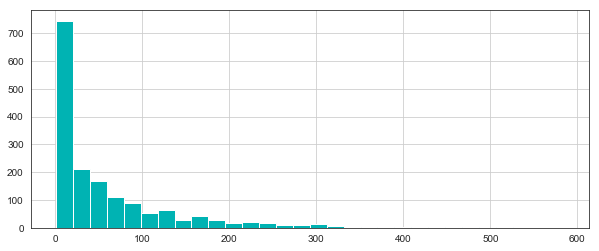

In [66]:
plt.figure(figsize=(10,4))
ratings['total count'].hist(bins=30, color='#00b3b3')

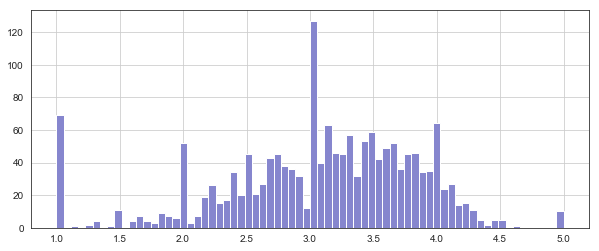

In [67]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70, color='#8686ce')

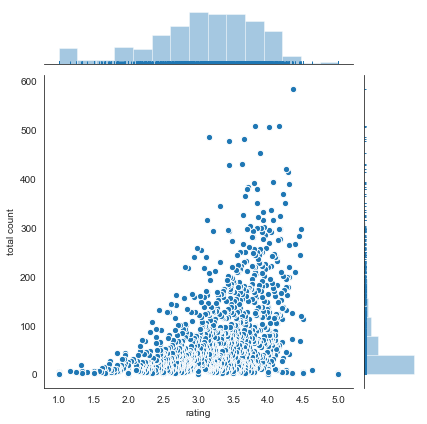

In [78]:
 sns.jointplot(x=ratings['rating'],y=ratings['total count'],data=ratings, marginal_kws=dict(bins=15, rug=True),
                  annot_kws=dict(stat="r"),
                  s=40, edgecolor="w", linewidth=1)

as we can see Movies with highest number of reviews usually have an average rating of 3 to 4.

## Recommending Similar Movies

Now we have analysed the data so next comes the recommendation. we need to plot every users record for available movies(those for which he has given reviews and those for which no review is given yet). let's create a matrix that has the user ids on one access and the movie title on another axis. There will be a lot of missing values or NaN values, because most people see only a few movies. we need to recommend those movies names to users which matches most to his/her preference.

In [87]:
#pivot data so that we can have data for each user in a row.


In [110]:
userdata = df.pivot_table(index='user_id',columns='title',values='rating')
userdata.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we need to perform regression analysis on for each user. Lets take 2 movies from data. lets takes star wars(scifi) and toy story(cartoon) both movies are of diffrent genres.

In [102]:
ratings.sort_values('total count',ascending=False).head(10)

,rating,total count
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Now let's plot the user ratings for those two movies:

In [103]:
#userdata.head()
starwars_user_ratings = pd.DataFrame(userdata['Star Wars (1977)'])
toystory_user_ratings = pd.DataFrame(userdata['Toy Story (1995)'])
starwars_user_ratings.head()

,Star Wars (1977)
user_id,
0,5.0
1,5.0
2,5.0
3,NaN
4,5.0


In [99]:
similar_to_starwars = userdata.corrwith(userdata['Star Wars (1977)'])
similar_to_toystory = userdata.corrwith(userdata['Toy Story (1995)'])
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

c:\users\preeti saraswat\appdata\local\programs\python\python35\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\preeti saraswat\appdata\local\programs\python\python35\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


We can then use corrwith() method to get correlations between two pandas series:

Now if we sort the dataframe by correlation, we will get the most similar movies, having highest correlation however  we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

In [104]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

Now sort the values and notice how the titles make a lot more sense:

In [106]:
corr_starwars = corr_starwars.join(ratings['total count'])
corr_starwars.head()


,Correlation,total count
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [107]:
corr_starwars[corr_starwars['total count']>50].sort_values('Correlation',ascending=False).head()

,Correlation,total count
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


In [ ]:
Now the same for the Toy story:

In [108]:
corr_Toystory = pd.DataFrame(similar_to_toystory,columns=['Correlation'])
corr_Toystory.dropna(inplace=True)
corr_Toystory = corr_Toystory.join(ratings['total count'])
corr_Toystory[corr_Toystory['total count']>50].sort_values('Correlation',ascending=False).head()

,Correlation,total count
title,,
Toy Story (1995),1.000000,452
Raise the Red Lantern (1991),0.641535,58
Flubber (1997),0.558389,53
"Jackal, The (1997)",0.557876,87
"Craft, The (1996)",0.549100,104
